In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from torch.distributions import constraints


In [ ]:
# Defining parameters as stochastic function

# deaths in hospitals / total deaths
def frac_dh():
    return torch.tensor(2985. / 6490.)

# fraction of hospitalized 
def hh():
    return torch.tensor(0.05)

# inverse recovery time
def gamma():
    return torch.tensor(1. / 12.4)

# inverse incubation time 
def epsilon():
    return torch.tensor(1. / 5.2)

# fatality rate in icu 
def dea():
    return torch.tensor(.5)

# population size
def n0():
    return torch.tensor(11000000.)

# population en MR/MRS + personnel soignant
def n0_MRS():
    return torch.tensor(400000.)

# e0 = i0 * factor
def e0_factor():
    return torch.tensor(37.)

# e0_MRS = i0_MRS * factor
def e0_MRS_factor():
    return torch.tensor(20.)

# size of the window for fitting Re's
def window():
    return torch.tensor(6.)

def i0():
    return pyro.sample("i0", dist.Poisson(10))()
    return torch.tensor(30.)

def r0_model(r0_mean):
    return r0

def drea():
    return dea()/ 5. 
    
def rrea():
    return (1 - dea())/20.
    
def hospi():
    return torch.tensor(0.0)

def gg():
    return torch.tensor(.75)

In [ ]:
opts = {}
opts["window"] = 3

In [ ]:
def smoothen(v, n_pts=opts["window"]):
    return v
    box = np.ones(n_pts) / n_pts
    return np.convolve(v, box, mode="same")

def SEIR(r0, n_futures=0, window=6):   
    # Smoothen and extend R0s
    r0 = torch.cat((r0, torch.ones(window + n_futures) * r0[-1]))

    # Initial conditions
    n = [n0()-n0_MRS()] # Population totale
    i = [i0()] # Symptomatiques
    e = [i0() * e0_factor()] # Asymptomatiques
    h = [torch.tensor(.0)] # Lits occupés hopital
    l = [torch.tensor(.0)] # Lits occupés USI
    r = [torch.tensor(.0)] # Immunisés
    m = [torch.tensor(.0)] # Morts (totaux)
    s = [n[-1] - e[-1] - i[-1] - r[-1]] # Sains
    
    # Simulate forward
    n_days = len(r0)
    
    hospi = 0.
    for day in range(n_days):
        lam = gamma() * r0[day]
        
        if day == 14:
            hospi = hh() / 7
            
        ds = -lam * (i[-1] / 2 + e[-1]) * s[-1] / n[-1]
        de = lam * (i[-1] / 2 + e[-1]) * s[-1] / n[-1] - epsilon() * e[-1]
        di = epsilon() * e[-1] - gamma() * i[-1] - hospi * i[-1]
        dh = hospi * i[-1] - gg() * h[-1] / 7 - (1 - gg()) * h[-1] / (4. + 2 * torch.tanh((l[-1]-500.)/300.))
        dl = (1 - gg()) * h[-1] / (4 + 2 * torch.tanh((l[-1]-500)/300)) - drea() * l[-1] - rrea() * l[-1]
        dr = gamma() * i[-1] + rrea() * l[-1] + gg() * h[-1] / 7
        dm = drea() * l[-1] 
        
        s.append(s[-1] + ds)
        e.append(e[-1] + de)
        i.append(i[-1] + di)
        h.append(h[-1] + dh)
        l.append(l[-1] + dl)
        if l[-1] > 1895:
            dm = dm + (l[-1] - 1895)
            l[-1] = torch.tensor(1895.)
        r.append(r[-1] + dr)
        m.append(m[-1] + dm)
        n.append(s[-1] + e[-1] + i[-1] + h[-1] + l[-1] + r[-1])
    return s, e, i, h, l, m, r

def SEIR_MRS(r0_mrs, n_futures=0, window=6):    
    # Smoothen and extend R0s
    r0_mrs = torch.cat((r0_mrs, torch.ones(window + n_futures) * r0_mrs[-1]))
    
    # Initial conditions
    alpha = 0.15 / 10
    lam = gamma() * 4.3
    
    n = [n0_MRS()]
    i = [1]
    e = [i[-1] * e0_MRS_factor()]
    r = [0.0]
    s = [n[-1] - e[-1] - i[-1] - r[-1]]
    m = [0.0]
    
    # Simulate forward
    n_days = len(r0_mrs)
    
    for day in range(n_days):
        lam = gamma() * r0_mrs[day]
        
        ds = -lam * (i[-1] / 2 + e[-1]) * s[-1] / n[-1]
        de = lam * (i[-1] / 2 + e[-1]) * s[-1] / n[-1] - epsilon() * e[-1]
        di = epsilon() * e[-1] - (gamma() + alpha) * i[-1]
        dr = gamma() * i[-1]
        dm = alpha * i[-1]
        
        s.append(s[-1] + ds)
        e.append(e[-1] + de)
        i.append(i[-1] + di)
        r.append(r[-1] + dr)
        m.append(m[-1] + dm)
        n.append(s[-1] + e[-1] + i[-1] + r[-1])
        
    return s, e, i, m, r

In [ ]:
def poisson_noiser(mu):
    #if mu < 5:
    #    print(mu)
    return dist.ZeroInflatedPoisson(torch.tensor(.0001), mu + 1)

def no_noiser(mu):
    return mu

In [ ]:
fake_R0 = torch.rand(30)*.1 + 1.5
fake_R0_RMS = torch.rand(30)*.1 + 3.5
s_o, e_o, i_o, h_o, l_o, m_o, r_o = SEIR(fake_R0, n_futures=0)
_, _, _, m_mrs_o, _ = SEIR_MRS(fake_R0_RMS, n_futures=0)
print(fake_R0)
print(fake_R0_RMS)

In [ ]:
noiser = poisson_noiser
def SEIR_full_model(r0_guess, r0_mrs_guess):    
    n_futures=0
    # Simulate
    r0 = pyro.sample("r0", dist.Uniform(torch.zeros_like(r0_guess), r0_guess + 5.))
    r0_mrs = pyro.sample("r0_mrs", dist.Uniform(torch.zeros_like(r0_mrs_guess), r0_mrs_guess + 5.))
    s_T, e_T, i_T, h_T, l_T, m_T, r_T = SEIR(r0, n_futures=n_futures)
    _, _, _, m_mrs_T, _ = SEIR_MRS(r0_mrs, n_futures=n_futures)
    for idx, (i, h, l, m, m_mrs) in enumerate(zip(i_T, h_T, l_T, m_T, m_mrs_T)):
        if idx > 15:
            pyro.sample("i_%d" % idx, noiser(i))
            pyro.sample("h_%d" % idx, noiser(h))
            pyro.sample("l_%d" % idx, noiser(l))
            pyro.sample("m_%d" % idx, noiser(m))
            pyro.sample("m_mrs_%d" % idx, noiser(m_mrs))
    return s_T, e_T, i_T, h_T, l_T, m_T, m_mrs_T, r_T

In [ ]:
def conditioned_seir(i_observed, h_observed, l_observed, m_observed, m_mrs_observed, r0, r0_mrs):
    data = {}
    for idx, (i, h, l, m, m_mrs) in enumerate(zip(i_observed, h_observed, l_observed, m_observed, m_mrs_observed)):
        if idx > 15:
            data["i_%d" % idx] = i
            data["h_%d" % idx] = h
            data["l_%d" % idx] = l
            data["m_%d" % idx] = m
            data["m_mrs_%d" % idx] = m_mrs
    return pyro.condition(SEIR_full_model, data=data)(r0, r0_mrs)

# Variational Inference

In [ ]:
def SEIR_guide(r0_guess, r0_mrs_guess):
    a_r0 = pyro.param("a_r0", torch.tensor(.5), constraint=constraints.positive)
    a_r0_mrs = pyro.param("a_r0_mrs", torch.tensor(.5), constraint=constraints.positive)
    b_r0 = pyro.param("b_r0", torch.tensor(3.5), constraint=constraints.positive)
    b_r0_mrs = pyro.param("b_r0_mrs", torch.tensor(3.5), constraint=constraints.positive)
    
    pyro.sample("r0", dist.Uniform(a_r0*torch.ones_like(r0_guess), (a_r0 + b_r0)*torch.ones_like(r0_guess)))
    pyro.sample("r0_mrs", dist.Uniform(a_r0_mrs*torch.ones_like(r0_mrs_guess), 
                                       (a_r0_mrs + b_r0_mrs)*torch.ones_like(r0_mrs_guess)))


In [ ]:
guess_R0 = 2.5*torch.ones_like(fake_R0)
guess_R0_RMS = 2.5*torch.ones_like(fake_R0_RMS)
pyro.clear_param_store()
# setup the optimizer
adam_params = {"lr": 0.001, "betas": (0.90, 0.999)}
optimizer = pyro.optim.Adam(adam_params)
svi = pyro.infer.SVI(model=lambda R0, R0_RMS: conditioned_seir(i_o, h_o, l_o, m_o, m_mrs_o, R0, R0_RMS),
                     guide=SEIR_guide,
                     optim=optimizer,
                     loss=pyro.infer.JitTrace_ELBO())


In [ ]:
%%time
losses, a,b  = [], [], []
num_steps = 20000
for t in range(num_steps):
    #print(svi.step(guess_R0, guess_R0_RMS))
    #print('r0 = ',pyro.param("a_r0"), pyro.param("b_r0"))
    losses.append(svi.step(guess_R0, guess_R0_RMS))
    if t % 1000 == 0:
        print('r0 = ',pyro.param("a_r0"), pyro.param("a_r0") + pyro.param("b_r0"))
        print('r0_mrs = ', pyro.param("a_r0_mrs"), pyro.param("a_r0_mrs") + pyro.param("b_r0_mrs"))
        print(losses[-1])


plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
print('r0 = ',pyro.param("a_r0"), pyro.param("a_r0") + pyro.param("b_r0"))
print('r0_mrs = ', pyro.param("a_r0_mrs"), pyro.param("a_r0_mrs") + pyro.param("b_r0_mrs"))

# MCMC

In [ ]:
from pyro.infer.mcmc import MCMC, NUTS


In [ ]:
fake_R0 = torch.rand(30)*.1 + 1.5
fake_R0_RMS = torch.rand(30)*.1 + 3.5
s_o, e_o, i_o, h_o, l_o, m_o, r_o = SEIR(fake_R0, n_futures=0)
_, _, _, m_mrs_o, _ = SEIR_MRS(fake_R0_RMS, n_futures=0)
print(fake_R0)
print(fake_R0_RMS)
data = {}
for idx, (i, h, l, m, m_mrs) in enumerate(zip(i_o, h_o, l_o, m_o, m_mrs_o)):
    if idx > 15:
        data["i_%d" % idx] = i
        data["h_%d" % idx] = h
        data["l_%d" % idx] = l
        data["m_%d" % idx] = m
        data["m_mrs_%d" % idx] = m_mrs

In [ ]:
def mcmc_seir_full_model(data):
    guess_R0 = 2.5*torch.ones_like(fake_R0)
    guess_R0_RMS = 2.5*torch.ones_like(fake_R0_RMS)
    return pyro.condition(SEIR_full_model, data=data)(guess_R0, guess_R0_RMS)

In [ ]:
%%time
nuts_kernel = NUTS(mcmc_seir_full_model, jit_compile=True, ignore_jit_warnings=True)
pyro.set_rng_seed(1)
mcmc = MCMC(nuts_kernel, num_samples=100)
mcmc.run(data)

In [ ]:
fake_R0

In [ ]:
mcmc.summary(prob=.5)

In [ ]:
nuts_kernel.diagnostics

# Suppose 2 R0

In [12]:
# Defining parameters as stochastic function

# deaths in hospitals / total deaths
def frac_dh():
    return torch.tensor(3470. / 7594.)

# fraction of hospitalized 
def hh():
    return torch.tensor(0.05)

# inverse recovery time
def gamma():
    return torch.tensor(1. / 12.4)

# inverse incubation time 
def epsilon():
    return torch.tensor(1. / 5.2)

# fatality rate in icu 
def dea():
    return torch.tensor(.5)

# population size
def n0():
    return torch.tensor(11000000.)

# population en MR/MRS + personnel soignant
def n0_MRS():
    return torch.tensor(400000.)

# e0 = i0 * factor
def e0_factor():
    return torch.tensor(37.)

# e0_MRS = i0_MRS * factor
def e0_MRS_factor():
    return torch.tensor(20.)

# size of the window for fitting Re's
def window():
    return torch.tensor(6.)

def i0():
    #return pyro.sample("i0", dist.Poisson(10))
    return torch.tensor(30.)

def r0_model(r0_mean):
    return r0

def drea():
    return dea()/ 5. 
    
def rrea():
    return (1 - dea())/20.
    
def hospi():
    return torch.tensor(0.0)

def gg():
    return torch.tensor(.75)

In [108]:
def SEIR(r0):   
    # Initial conditions
    n = [n0()] # Population totale
    i = [i0()] # Symptomatiques
    e = [i[0] * e0_factor()] # Asymptomatiques
    h = [torch.tensor(.0)] # Lits occupés hopital
    l = [torch.tensor(.0)] # Lits occupés USI
    r = [torch.tensor(.0)] # Immunisés
    m = [torch.tensor(.0)] # Morts (totaux)
    s = [n[-1] - e[-1] - i[-1] - r[-1]] # Sains
    
    # Simulate forward
    n_days = len(r0)
    
    hospi = 0.
    for day in range(n_days):
        lam = gamma() * r0[day]
        
        if day == 14:
            hospi = hh() / 7
            
        ds = -lam * (i[-1] / 2 + e[-1]) * s[-1] / n[-1]
        de = lam * (i[-1] / 2 + e[-1]) * s[-1] / n[-1] - epsilon() * e[-1]
        di = epsilon() * e[-1] - gamma() * i[-1] - hospi * i[-1]
        dh = hospi * i[-1] - gg() * h[-1] / 7 - (1 - gg()) * h[-1] / (4. + 2 * torch.tanh((l[-1]-500.)/300.))
        dl = (1 - gg()) * h[-1] / (4 + 2 * torch.tanh((l[-1]-500)/300)) - drea() * l[-1] - rrea() * l[-1]
        dr = gamma() * i[-1] + rrea() * l[-1] + gg() * h[-1] / 7
        dm = drea() * l[-1] 
        
        s.append(s[-1] + ds)
        e.append(e[-1] + de)
        i.append(i[-1] + di)
        h.append(h[-1] + dh)
        l.append(l[-1] + dl)
        if l[-1] > 1895:
            dm = dm + (l[-1] - 1895)
            l[-1] = torch.tensor(1895.)
        r.append(r[-1] + dr)
        m.append(m[-1] + dm)
        n.append(s[-1] + e[-1] + i[-1] + h[-1] + l[-1] + r[-1])
    return s, e, i, h, l, m, r
def SEIR_MRS(r0_mrs, n_futures=0, window=6):    
    # Smoothen and extend R0s
    
    # Initial conditions
    alpha = 0.15 / 10
    lam = gamma() * 4.3
    
    n = [n0_MRS()]
    i = [torch.tensor(1)]
    e = [i[-1] * e0_MRS_factor()]
    r = [torch.tensor(0.0)]
    s = [n[-1] - e[-1] - i[-1] - r[-1]]
    m = [torch.tensor(0.0)]
    
    # Simulate forward
    n_days = len(r0_mrs)
    
    for day in range(n_days):
        lam = gamma() * r0_mrs[day]
        
        ds = -lam * (i[-1] / 2 + e[-1]) * s[-1] / n[-1]
        de = lam * (i[-1] / 2 + e[-1]) * s[-1] / n[-1] - epsilon() * e[-1]
        di = epsilon() * e[-1] - (gamma() + alpha) * i[-1]
        dr = gamma() * i[-1]
        dm = alpha * i[-1]
        
        s.append(s[-1] + ds)
        e.append(e[-1] + de)
        i.append(i[-1] + di)
        r.append(r[-1] + dr)
        m.append(m[-1] + dm)
        n.append(s[-1] + e[-1] + i[-1] + r[-1])
        
    return s, e, i, m, r

In [100]:
from pyro.infer.mcmc import MCMC, NUTS
import matplotlib.pyplot as plt
import numpy as np
import torch

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from torch.distributions import constraints

import seaborn

(source: [wikipedia covid-19 Belgique](https://fr.wikipedia.org/wiki/Pand%C3%A9mie_de_Covid-19_en_Belgique))
- 11 Mars arrêt des visites en mrs. (13)
- 16 Mars plus de cours. (18)
- 18 Mars confinement. (20)
- 20 avril magasin de bricolage et pépinieriste ouvrent à nouveau. (22)

Nos données débutent au 28 février

In [156]:
date_r0_switch = 20
date_r0_switch_mrs = 13

In [44]:
from covid19be import load_data
data_df = load_data()

In [45]:
data_df[3:].head()

,n_hospitalized,n_hospitalized_in,n_hospitalized_out,n_icu,n_daily_deaths,date,n_deaths
4,0,0,0,0,0,2020-03-02,0
5,0,0,0,0,0,2020-03-03,0
6,0,0,0,0,0,2020-03-04,0
7,0,0,0,0,0,2020-03-05,0
8,0,0,0,0,0,2020-03-06,0


In [46]:
n_days = len(data_df)
n_days

62

In [72]:
nb_dirty_data = 4
n_useful_days = n_days - nb_dirty_data

In [73]:
mrs = True
noiser = lambda mu: dist.ZeroInflatedPoisson(torch.tensor(.0001), mu + 1)

In [167]:
def SEIR_full_model_bis(ret_data=False):    
    n_futures=0
    # Simulate
    r0_1 = pyro.sample("r0_1", dist.Uniform(torch.tensor(0.), torch.tensor(6.)))
    r0_2 = pyro.sample("r0_2", dist.Uniform(torch.tensor(0.), torch.tensor(3.)))
    # R0 fluctuates around its means that are given by r0_1 and r0_2
    r0 = torch.cat((dist.Uniform(torch.ones(date_r0_switch - 1) * r0_1 - .2, 
                                 torch.ones(date_r0_switch - 1) * r0_1 + .2)(), 
                    dist.Uniform(torch.ones(n_useful_days - date_r0_switch + 1) * r0_2 - .2, 
                                 torch.ones(n_useful_days - date_r0_switch + 1) * r0_2 + .2)()))
    s_T, e_T, i_T, h_T, l_T, m_T, r_T = SEIR(r0)
    #print(r0)
    if mrs:
        r0_mrs_1 = pyro.sample("r0_mrs_1", dist.Uniform(.0, 6.))
        r0_mrs_2 = pyro.sample("r0_mrs_2", dist.Uniform(.0, 3.))
        data_r0_mrs_switch = 11
        r0_mrs = torch.cat((dist.Uniform(torch.ones(date_r0_switch_mrs - 1) * r0_mrs_1 - .2, 
                                              torch.ones(date_r0_switch_mrs - 1) * r0_mrs_1 + .2)(), 
                            dist.Uniform(torch.ones(n_useful_days - date_r0_switch_mrs + 1) * r0_mrs_2 - .2, 
                                          torch.ones(n_useful_days - date_r0_switch_mrs + 1) * r0_mrs_2 + .2)()))
    
        _, _, _, m_mrs_T, _ = SEIR_MRS(r0_mrs)
    for idx in range(n_useful_days):
        if idx > 16:
            if h_T[idx] < 0:
                print(h_T[idx])
            pyro.sample("h_%d" % idx, noiser(h_T[idx]))
            pyro.sample("l_%d" % idx, noiser(l_T[idx]))
            pyro.sample("m_%d" % idx, noiser(m_T[idx]))
            if mrs:
                pyro.sample("m_mrs_%d" % idx, noiser(m_mrs_T[idx]))
    if mrs and ret_data:
        return s_T, e_T, i_T, h_T, l_T, m_T, m_mrs_T, r_T
    if ret_data:
        return s_T, e_T, i_T, h_T, l_T, m_T, r_T

In [168]:
data = {}
hospi = data_df['n_hospitalized']
l = data_df['n_icu']
m = data_df['n_deaths']
for idx in range(n_useful_days):
    if idx > 16:
        data["h_%d" % idx] = torch.tensor(hospi[idx] - l[idx], dtype=torch.float)
        data["l_%d" % idx] = torch.tensor(l[idx], dtype=torch.float)
        data["m_%d" % idx] = torch.tensor(m[idx], dtype=torch.float)
        if mrs:
            data["m_mrs_%d" % idx] = torch.tensor(m[idx]*(1-frac_dh()))


<ipython-input-168-5996d6a0ac0c>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data["m_mrs_%d" % idx] = torch.tensor(m[idx]*(1-frac_dh()))


In [169]:
def r0_guide(ret_data=False):    
    a_r0_1 = pyro.param("a_r0_1", torch.tensor(2.), constraint=constraints.positive)
    a_r0_2 = pyro.param("a_r0_2", torch.tensor(.25), constraint=constraints.positive)
    b_r0_1 = pyro.param("b_r0_1", torch.tensor(4.), constraint=constraints.positive)
    b_r0_2 = pyro.param("b_r0_2", torch.tensor(1.25), constraint=constraints.positive)
    r0_1 = pyro.sample("r0_1", dist.Uniform(a_r0_1, a_r0_1 + b_r0_1))
    r0_2 = pyro.sample("r0_2", dist.Uniform(a_r0_2, a_r0_2 + b_r0_2))
    if mrs:
        a_r0_mrs_1 = pyro.param("a_r0_mrs_1", torch.tensor(2.), constraint=constraints.positive)
        a_r0_mrs_2 = pyro.param("a_r0_mrs_2", torch.tensor(.25), constraint=constraints.positive)
        b_r0_mrs_1 = pyro.param("b_r0_mrs_1", torch.tensor(4.), constraint=constraints.positive)
        b_r0_mrs_2 = pyro.param("b_r0_mrs_2", torch.tensor(1.25), constraint=constraints.positive)
        r0_mrs_1 = pyro.sample("r0_mrs_1", dist.Uniform(a_r0_mrs_1, a_r0_mrs_1 + b_r0_mrs_1))
        r0_mrs_2 = pyro.sample("r0_mrs_2", dist.Uniform(a_r0_mrs_2, a_r0_mrs_2 + b_r0_mrs_2))
        
    if ret_data:
        # R0 fluctuates around its means that are given by r0_1 and r0_2
        r0 = torch.cat((dist.Uniform(torch.ones(date_r0_switch - 1) * r0_1 - .2, 
                                     torch.ones(date_r0_switch - 1) * r0_1 + .2)(), 
                        dist.Uniform(torch.ones(n_useful_days - date_r0_switch + 1) * r0_2 - .2, 
                                     torch.ones(n_useful_days - date_r0_switch + 1) * r0_2 + .2)()))
        s_T, e_T, i_T, h_T, l_T, m_T, r_T = SEIR(r0)
        #print(r0)
        if mrs:
            date_r0_switch_mrs = 13
            r0_mrs = torch.cat((dist.Uniform(torch.ones(date_r0_switch_mrs - 1) * r0_mrs_1 - .2, 
                                              torch.ones(date_r0_switch_mrs - 1) * r0_mrs_1 + .2)(), 
                                dist.Uniform(torch.ones(n_useful_days - date_r0_switch_mrs + 1) * r0_mrs_2 - .2, 
                                              torch.ones(n_useful_days - date_r0_switch_mrs + 1) * r0_mrs_2 + .2)()))

            _, _, _, m_mrs_T, _ = SEIR_MRS(r0_mrs)
        for idx in range(n_useful_days):
            if idx > 16:
                pyro.sample("h_%d" % idx, noiser(h_T[idx]))
                pyro.sample("l_%d" % idx, noiser(l_T[idx]))
                pyro.sample("m_%d" % idx, noiser(m_T[idx]))
                if mrs:
                    pyro.sample("m_mrs_%d" % idx, noiser(m_mrs_T[idx]))
        if mrs and ret_data:
            return s_T, e_T, i_T, h_T, l_T, m_T, m_mrs_T, r_T
        if ret_data:
            return s_T, e_T, i_T, h_T, l_T, m_T, r_T

In [170]:
pyro.clear_param_store()
# setup the optimizer
adam_params = {"lr": 0.001, "betas": (0.90, 0.999)}
optimizer = pyro.optim.Adam(adam_params)
svi = pyro.infer.SVI(model=pyro.condition(SEIR_full_model_bis, data=data),
                     guide=r0_guide,
                     optim=optimizer,
                     loss=pyro.infer.JitTrace_ELBO())


In [177]:
%%time
losses, a,b  = [], [], []
num_steps = 20000
for t in range(num_steps):
    #print(svi.step(guess_R0, guess_R0_RMS))
    #print('r0 = ',pyro.param("a_r0"), pyro.param("b_r0"))
    losses.append(svi.step())
    if t % 100 == 0:
        print('r0 before lock-down ',pyro.param("a_r0_1"), pyro.param("a_r0_1") + pyro.param("b_r0_1"))
        print('r0 after lock-down ', pyro.param("a_r0_2"), pyro.param("a_r0_2") + pyro.param("b_r0_2"))
        print('r0 mrs before lock-down ',pyro.param("a_r0_mrs_1"), pyro.param("a_r0_mrs_1") + pyro.param("b_r0_mrs_1"))
        print('r0 mrs after lock-down ', pyro.param("a_r0_mrs_2"), pyro.param("a_r0_mrs_2") + pyro.param("b_r0_mrs_2"))
        print(losses[-1])

r0 before lock-down  tensor(4.8176, grad_fn=<AddBackward0>) tensor(4.9027, grad_fn=<AddBackward0>)
r0 after lock-down  tensor(0.6933, grad_fn=<AddBackward0>) tensor(0.7949, grad_fn=<AddBackward0>)
r0 mrs before lock-down  tensor(6.3895, grad_fn=<AddBackward0>) tensor(6.5778, grad_fn=<AddBackward0>)
r0 mrs after lock-down  tensor(2.1038, grad_fn=<AddBackward0>) tensor(2.1935, grad_fn=<AddBackward0>)
inf
r0 before lock-down  tensor(4.8030, grad_fn=<AddBackward0>) tensor(4.8864, grad_fn=<AddBackward0>)
r0 after lock-down  tensor(0.6928, grad_fn=<AddBackward0>) tensor(0.7923, grad_fn=<AddBackward0>)
r0 mrs before lock-down  tensor(6.4054, grad_fn=<AddBackward0>) tensor(6.5917, grad_fn=<AddBackward0>)
r0 mrs after lock-down  tensor(2.1106, grad_fn=<AddBackward0>) tensor(2.1992, grad_fn=<AddBackward0>)
inf
r0 before lock-down  tensor(4.8090, grad_fn=<AddBackward0>) tensor(4.8909, grad_fn=<AddBackward0>)
r0 after lock-down  tensor(0.6928, grad_fn=<AddBackward0>) tensor(0.7908, grad_fn=<AddBac

r0 before lock-down  tensor(4.8236, grad_fn=<AddBackward0>) tensor(4.8855, grad_fn=<AddBackward0>)
r0 after lock-down  tensor(0.7104, grad_fn=<AddBackward0>) tensor(0.7843, grad_fn=<AddBackward0>)
r0 mrs before lock-down  tensor(6.4326, grad_fn=<AddBackward0>) tensor(6.5662, grad_fn=<AddBackward0>)
r0 mrs after lock-down  tensor(2.1252, grad_fn=<AddBackward0>) tensor(2.1890, grad_fn=<AddBackward0>)
inf
r0 before lock-down  tensor(4.8001, grad_fn=<AddBackward0>) tensor(4.8607, grad_fn=<AddBackward0>)
r0 after lock-down  tensor(0.7079, grad_fn=<AddBackward0>) tensor(0.7807, grad_fn=<AddBackward0>)
r0 mrs before lock-down  tensor(6.4113, grad_fn=<AddBackward0>) tensor(6.5433, grad_fn=<AddBackward0>)
r0 mrs after lock-down  tensor(2.1161, grad_fn=<AddBackward0>) tensor(2.1788, grad_fn=<AddBackward0>)
inf
r0 before lock-down  tensor(4.8197, grad_fn=<AddBackward0>) tensor(4.8796, grad_fn=<AddBackward0>)
r0 after lock-down  tensor(0.7088, grad_fn=<AddBackward0>) tensor(0.7809, grad_fn=<AddBac

r0 before lock-down  tensor(4.8142, grad_fn=<AddBackward0>) tensor(4.8592, grad_fn=<AddBackward0>)
r0 after lock-down  tensor(0.7152, grad_fn=<AddBackward0>) tensor(0.7702, grad_fn=<AddBackward0>)
r0 mrs before lock-down  tensor(6.4304, grad_fn=<AddBackward0>) tensor(6.5297, grad_fn=<AddBackward0>)
r0 mrs after lock-down  tensor(2.1270, grad_fn=<AddBackward0>) tensor(2.1737, grad_fn=<AddBackward0>)
inf
r0 before lock-down  tensor(4.8285, grad_fn=<AddBackward0>) tensor(4.8729, grad_fn=<AddBackward0>)
r0 after lock-down  tensor(0.7175, grad_fn=<AddBackward0>) tensor(0.7719, grad_fn=<AddBackward0>)
r0 mrs before lock-down  tensor(6.4354, grad_fn=<AddBackward0>) tensor(6.5330, grad_fn=<AddBackward0>)
r0 mrs after lock-down  tensor(2.1279, grad_fn=<AddBackward0>) tensor(2.1739, grad_fn=<AddBackward0>)
inf
r0 before lock-down  tensor(4.8367, grad_fn=<AddBackward0>) tensor(4.8808, grad_fn=<AddBackward0>)
r0 after lock-down  tensor(0.7199, grad_fn=<AddBackward0>) tensor(0.7737, grad_fn=<AddBac

r0 before lock-down  tensor(4.8350, grad_fn=<AddBackward0>) tensor(4.8698, grad_fn=<AddBackward0>)
r0 after lock-down  tensor(0.7270, grad_fn=<AddBackward0>) tensor(0.7702, grad_fn=<AddBackward0>)
r0 mrs before lock-down  tensor(6.4498, grad_fn=<AddBackward0>) tensor(6.5265, grad_fn=<AddBackward0>)
r0 mrs after lock-down  tensor(2.1351, grad_fn=<AddBackward0>) tensor(2.1703, grad_fn=<AddBackward0>)
inf
r0 before lock-down  tensor(4.8320, grad_fn=<AddBackward0>) tensor(4.8664, grad_fn=<AddBackward0>)
r0 after lock-down  tensor(0.7282, grad_fn=<AddBackward0>) tensor(0.7710, grad_fn=<AddBackward0>)
r0 mrs before lock-down  tensor(6.4409, grad_fn=<AddBackward0>) tensor(6.5161, grad_fn=<AddBackward0>)
r0 mrs after lock-down  tensor(2.1315, grad_fn=<AddBackward0>) tensor(2.1662, grad_fn=<AddBackward0>)
inf
r0 before lock-down  tensor(4.8213, grad_fn=<AddBackward0>) tensor(4.8555, grad_fn=<AddBackward0>)
r0 after lock-down  tensor(0.7263, grad_fn=<AddBackward0>) tensor(0.7685, grad_fn=<AddBac

r0 before lock-down  tensor(4.8333, grad_fn=<AddBackward0>) tensor(4.8613, grad_fn=<AddBackward0>)
r0 after lock-down  tensor(0.7320, grad_fn=<AddBackward0>) tensor(0.7661, grad_fn=<AddBackward0>)
r0 mrs before lock-down  tensor(6.4608, grad_fn=<AddBackward0>) tensor(6.5219, grad_fn=<AddBackward0>)
r0 mrs after lock-down  tensor(2.1433, grad_fn=<AddBackward0>) tensor(2.1711, grad_fn=<AddBackward0>)
inf
r0 before lock-down  tensor(4.8287, grad_fn=<AddBackward0>) tensor(4.8564, grad_fn=<AddBackward0>)
r0 after lock-down  tensor(0.7297, grad_fn=<AddBackward0>) tensor(0.7636, grad_fn=<AddBackward0>)
r0 mrs before lock-down  tensor(6.4473, grad_fn=<AddBackward0>) tensor(6.5076, grad_fn=<AddBackward0>)
r0 mrs after lock-down  tensor(2.1387, grad_fn=<AddBackward0>) tensor(2.1662, grad_fn=<AddBackward0>)
inf
r0 before lock-down  tensor(4.8325, grad_fn=<AddBackward0>) tensor(4.8601, grad_fn=<AddBackward0>)
r0 after lock-down  tensor(0.7293, grad_fn=<AddBackward0>) tensor(0.7629, grad_fn=<AddBac

r0 before lock-down  tensor(4.8343, grad_fn=<AddBackward0>) tensor(4.8579, grad_fn=<AddBackward0>)
r0 after lock-down  tensor(0.7314, grad_fn=<AddBackward0>) tensor(0.7593, grad_fn=<AddBackward0>)
r0 mrs before lock-down  tensor(6.4456, grad_fn=<AddBackward0>) tensor(6.4965, grad_fn=<AddBackward0>)
r0 mrs after lock-down  tensor(2.1369, grad_fn=<AddBackward0>) tensor(2.1599, grad_fn=<AddBackward0>)
inf
r0 before lock-down  tensor(4.8267, grad_fn=<AddBackward0>) tensor(4.8502, grad_fn=<AddBackward0>)
r0 after lock-down  tensor(0.7315, grad_fn=<AddBackward0>) tensor(0.7593, grad_fn=<AddBackward0>)
r0 mrs before lock-down  tensor(6.4515, grad_fn=<AddBackward0>) tensor(6.5022, grad_fn=<AddBackward0>)
r0 mrs after lock-down  tensor(2.1386, grad_fn=<AddBackward0>) tensor(2.1613, grad_fn=<AddBackward0>)
inf
r0 before lock-down  tensor(4.8424, grad_fn=<AddBackward0>) tensor(4.8656, grad_fn=<AddBackward0>)
r0 after lock-down  tensor(0.7337, grad_fn=<AddBackward0>) tensor(0.7616, grad_fn=<AddBac

r0 before lock-down  tensor(4.8291, grad_fn=<AddBackward0>) tensor(4.8495, grad_fn=<AddBackward0>)
r0 after lock-down  tensor(0.7337, grad_fn=<AddBackward0>) tensor(0.7585, grad_fn=<AddBackward0>)
r0 mrs before lock-down  tensor(6.4684, grad_fn=<AddBackward0>) tensor(6.5121, grad_fn=<AddBackward0>)
r0 mrs after lock-down  tensor(2.1457, grad_fn=<AddBackward0>) tensor(2.1649, grad_fn=<AddBackward0>)
inf
r0 before lock-down  tensor(4.8143, grad_fn=<AddBackward0>) tensor(4.8346, grad_fn=<AddBackward0>)
r0 after lock-down  tensor(0.7312, grad_fn=<AddBackward0>) tensor(0.7559, grad_fn=<AddBackward0>)
r0 mrs before lock-down  tensor(6.4601, grad_fn=<AddBackward0>) tensor(6.5037, grad_fn=<AddBackward0>)
r0 mrs after lock-down  tensor(2.1434, grad_fn=<AddBackward0>) tensor(2.1624, grad_fn=<AddBackward0>)
inf
r0 before lock-down  tensor(4.8439, grad_fn=<AddBackward0>) tensor(4.8640, grad_fn=<AddBackward0>)
r0 after lock-down  tensor(0.7350, grad_fn=<AddBackward0>) tensor(0.7598, grad_fn=<AddBac

r0 before lock-down  tensor(4.8308, grad_fn=<AddBackward0>) tensor(4.8485, grad_fn=<AddBackward0>)
r0 after lock-down  tensor(0.7322, grad_fn=<AddBackward0>) tensor(0.7543, grad_fn=<AddBackward0>)
r0 mrs before lock-down  tensor(6.4666, grad_fn=<AddBackward0>) tensor(6.5063, grad_fn=<AddBackward0>)
r0 mrs after lock-down  tensor(2.1450, grad_fn=<AddBackward0>) tensor(2.1618, grad_fn=<AddBackward0>)
inf
r0 before lock-down  tensor(4.8575, grad_fn=<AddBackward0>) tensor(4.8752, grad_fn=<AddBackward0>)
r0 after lock-down  tensor(0.7347, grad_fn=<AddBackward0>) tensor(0.7567, grad_fn=<AddBackward0>)
r0 mrs before lock-down  tensor(6.4551, grad_fn=<AddBackward0>) tensor(6.4946, grad_fn=<AddBackward0>)
r0 mrs after lock-down  tensor(2.1409, grad_fn=<AddBackward0>) tensor(2.1577, grad_fn=<AddBackward0>)
inf
r0 before lock-down  tensor(4.8494, grad_fn=<AddBackward0>) tensor(4.8668, grad_fn=<AddBackward0>)
r0 after lock-down  tensor(0.7347, grad_fn=<AddBackward0>) tensor(0.7565, grad_fn=<AddBac

r0 before lock-down  tensor(4.8388, grad_fn=<AddBackward0>) tensor(4.8545, grad_fn=<AddBackward0>)
r0 after lock-down  tensor(0.7329, grad_fn=<AddBackward0>) tensor(0.7527, grad_fn=<AddBackward0>)
r0 mrs before lock-down  tensor(6.4586, grad_fn=<AddBackward0>) tensor(6.4940, grad_fn=<AddBackward0>)
r0 mrs after lock-down  tensor(2.1449, grad_fn=<AddBackward0>) tensor(2.1600, grad_fn=<AddBackward0>)
inf
r0 before lock-down  tensor(4.8372, grad_fn=<AddBackward0>) tensor(4.8528, grad_fn=<AddBackward0>)
r0 after lock-down  tensor(0.7324, grad_fn=<AddBackward0>) tensor(0.7522, grad_fn=<AddBackward0>)
r0 mrs before lock-down  tensor(6.4682, grad_fn=<AddBackward0>) tensor(6.5035, grad_fn=<AddBackward0>)
r0 mrs after lock-down  tensor(2.1492, grad_fn=<AddBackward0>) tensor(2.1642, grad_fn=<AddBackward0>)
inf
r0 before lock-down  tensor(4.8475, grad_fn=<AddBackward0>) tensor(4.8630, grad_fn=<AddBackward0>)
r0 after lock-down  tensor(0.7367, grad_fn=<AddBackward0>) tensor(0.7565, grad_fn=<AddBac

r0 before lock-down  tensor(4.8495, grad_fn=<AddBackward0>) tensor(4.8632, grad_fn=<AddBackward0>)
r0 after lock-down  tensor(0.7387, grad_fn=<AddBackward0>) tensor(0.7564, grad_fn=<AddBackward0>)
r0 mrs before lock-down  tensor(6.4667, grad_fn=<AddBackward0>) tensor(6.4985, grad_fn=<AddBackward0>)
r0 mrs after lock-down  tensor(2.1461, grad_fn=<AddBackward0>) tensor(2.1597, grad_fn=<AddBackward0>)
inf
r0 before lock-down  tensor(4.8383, grad_fn=<AddBackward0>) tensor(4.8520, grad_fn=<AddBackward0>)
r0 after lock-down  tensor(0.7376, grad_fn=<AddBackward0>) tensor(0.7552, grad_fn=<AddBackward0>)
r0 mrs before lock-down  tensor(6.4731, grad_fn=<AddBackward0>) tensor(6.5046, grad_fn=<AddBackward0>)
r0 mrs after lock-down  tensor(2.1494, grad_fn=<AddBackward0>) tensor(2.1629, grad_fn=<AddBackward0>)
inf
r0 before lock-down  tensor(4.8449, grad_fn=<AddBackward0>) tensor(4.8585, grad_fn=<AddBackward0>)
r0 after lock-down  tensor(0.7377, grad_fn=<AddBackward0>) tensor(0.7553, grad_fn=<AddBac

In [178]:
n_points = 300
for i in range(n_points):
    if mrs:
        s_T, e_T, i_T, h_T, l_T, m_T, m_mrs_T, r_T = svi.guide(True)
    else:
        s_T, e_T, i_T, h_T, l_T, m_T, r_T = svi.guide(True)
    hospi_T = np.array(list(map(lambda x: (x[0] + x[1]).detach().numpy(), zip(h_T, l_T)))).reshape(-1, 1)
    l_T = np.array(list(map(lambda x: x.detach().numpy(), l_T))).reshape(-1, 1)
    m_T = np.array(list(map(lambda x: x.detach().numpy(), m_T))).reshape(-1, 1)
    m_mrs_T = np.array(list(map(lambda x: x.detach().numpy(), m_mrs_T))).reshape(-1, 1)
    if i == 0:
        h = hospi_T
        l = l_T
        m = m_T
        m_mrs = m_mrs_T
    else:
        h = np.append(h, hospi_T, axis=1)
        l = np.append(l, l_T, axis=1)
        m = np.append(m, m_T, axis=1)
        m_mrs = np.append(m_mrs, m_mrs_T, axis=1)


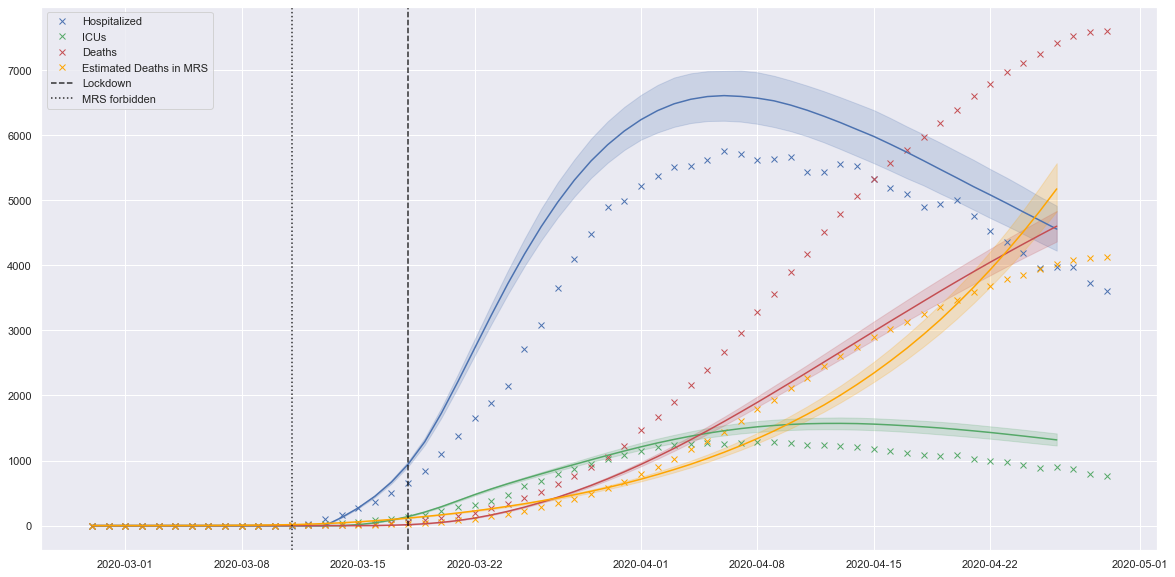

In [179]:
def get_percentiles(arr, color=None):
    arr_50 = np.percentile(arr, 50, axis=1)
    arr_5 = np.percentile(arr, 5, axis=1)
    arr_95 = np.percentile(arr, 95, axis=1)
    if color is not None:
        plt.plot(data_df['date'][:n_useful_days+1], arr_50, c=color)
        plt.fill_between(data_df['date'][:n_useful_days+1], arr_5, arr_95, color=color, alpha=0.2)
    return arr_50, arr_5, arr_95

seaborn.set()
fig = plt.figure(figsize=(20, 10))
plt.plot(data_df['date'], data_df['n_hospitalized'], 'x', color='b', label='Hospitalized')

plt.plot(data_df['date'], data_df['n_icu'], 'x', color='g', label='ICUs')
plt.plot(data_df['date'], data_df['n_deaths'], 'x', color='r', label='Deaths')
plt.plot(data_df['date'], data_df['n_deaths']*(1-frac_dh().item()), 'x', color='orange', label='Estimated Deaths in MRS')

get_percentiles(h, 'b')
get_percentiles(l, 'g')
get_percentiles(m, 'r')
get_percentiles(m_mrs, 'orange')


plt.axvline(data_df['date'][date_r0_switch], 0, 8500, label='Lockdown', c='black', alpha=.8, linestyle ='--')
plt.axvline(data_df['date'][date_r0_switch_mrs], 0, 8500, label='MRS forbidden', c='black', alpha=.8, linestyle=':')
plt.legend()

plt.savefig('pyro_SEIR.png')
plt.show()

In [ ]:
def mcmc_seir_full_model_bis(data):
    return pyro.condition(SEIR_full_model_bis, data=data)()

In [ ]:
%%time
nuts_kernel = NUTS(mcmc_seir_full_model_bis, jit_compile=False, ignore_jit_warnings=True)
pyro.set_rng_seed(1)
mcmc = MCMC(nuts_kernel, num_samples=100)
mcmc.run(data)
mcmc.summary(prob=.5)